## 深層学習での前処理の順序

分かち書き・正規化
- 単語毎に分割(分かち書き)・正規化(無駄な文字を削除)

ここまでをクレンジング(cleansing)という。

↓

単語埋め込み(Word Embedding)
- 単語をベクトル化

または、

単語をトークン化(Tokenize)
- 単語を一意の ID に変換

↓

パディング(Padding)・端数処理(truncating)

↓

学習モデルに入力

これらは、[言語処理100本ノック 2020 (Rev 2)](https://nlp100.github.io/ja/) にて勉強できる。


カリフォルニア大学アーバイン校がメンテナンスする559個のデータセットからなるリポジトリ

[UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)

In [1]:
import pandas as pd

df = pd.read_csv('./SMSSpamCollection', sep='\t', header=None)
df.rename({0: 'label', 1: 'text'}, axis=1, inplace=True)
df['category'] = df.apply(lambda r: 1 if r['label'] == 'spam' else 0, axis=1)

df.head()

,label,text,category
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


`sklearn 学習データ 分割`で検索し、`df[['text']], df[['category']]` を `X_train, X_test, Y_train, Y_test` に分割する

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    df[['text']], df[['category']], 
test_size=0.2, random_state=0
)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(4457, 1) (1115, 1) (4457, 1) (1115, 1)


In [3]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])
x_train = tokenizer.texts_to_sequences(X_train['text'])
x_test = tokenizer.texts_to_sequences(X_test['text'])

print(x_train[0:3])
X_train['text'].head(3)

[[38, 32, 56, 12, 5, 636, 9, 14, 47, 36, 1, 208, 8, 128, 3810], [36, 3, 204, 21, 51, 1, 29, 138, 949, 2527, 3811, 3812, 3813, 3814], [17, 3, 3815, 26, 185, 47, 404, 209, 740, 62, 4, 299, 3816]]


1114    No I'm good for the movie, is it ok if I leave...
3589    If you were/are free i can give. Otherwise nal...
3095    Have you emigrated or something? Ok maybe 5.30...
Name: text, dtype: object

In [4]:
from keras.preprocessing.sequence import pad_sequences

max_len = 100

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# x_trainの中身を確認
x_train

array([[   0,    0,    0, ...,    8,  128, 3810],
       [   0,    0,    0, ..., 3812, 3813, 3814],
       [   0,    0,    0, ...,    4,  299, 3816],
       ...,
       [   0,    0,    0, ..., 3415, 1981,  346],
       [   0,    0,    0, ...,   19,   11,  334],
       [   0,    0,    0, ...,   33,   20,  105]], dtype=int32)

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import Adam

batch_size = 32
epochs = 2

vocabulary_size = len(tokenizer.word_index) + 1 
model = Sequential()

model.add(Embedding(input_dim=vocabulary_size, output_dim=32))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          257920    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 261,073
Trainable params: 261,073
Non-trainable params: 0
_________________________________________________________________


In [6]:
y_train = Y_train['category'].values
y_test = Y_test['category'].values

history = model.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs,
    validation_data=(x_test, y_test)
)


Epoch 1/2
140/140 [==============================] - 12s 75ms/step - loss: 0.4720 - accuracy: 0.8711 - val_loss: 0.1277 - val_accuracy: 0.9758
Epoch 2/2
140/140 [==============================] - 10s 70ms/step - loss: 0.0957 - accuracy: 0.9860 - val_loss: 0.0686 - val_accuracy: 0.9857


In [7]:
texts = [
    "Are you single? Use this site to find women in their 20s who want to have sex right away! Pay $ 100 Now and Get FREE! 08717890890",
    "Are you single? Use this site to find women in their 20s who want to have sex right away! Pay $ 100 Now and Get FREE! 08717890890 http://porn.sex/xxx.asp?o=13543",
    "Hello. It is nice weather. It's time to see the cherry blossoms, so how about cherry blossom viewing together"
]
x = tokenizer.texts_to_sequences(texts)
x = pad_sequences(x, maxlen=max_len)

class_pred = model.predict_classes(x)
print(class_pred)

[[1]
 [1]
 [0]]


### 精度、再現率、F値を計算


In [24]:
from sklearn.metrics import confusion_matrix, precision_score,recall_score, f1_score

y_predict = model.predict(x_test)

cf_matrix = confusion_matrix(y_test,y_predict.round())
tn,fp,fn,tp = confusion_matrix(y_test,y_predict.round()).ravel()

print("精度(Precision): {:.2f}%".format(100 * precision_score(y_test, y_predict.round())))
print("再現率(Recall): {:.2f}%".format(100 * recall_score(y_test, y_predict.round())))
print("F値(F1 Score): {:.2f}%".format(100 * f1_score(y_test,y_predict.round())))

精度(Precision): 96.15%
再現率(Recall): 93.75%
F値(F1 Score): 94.94%


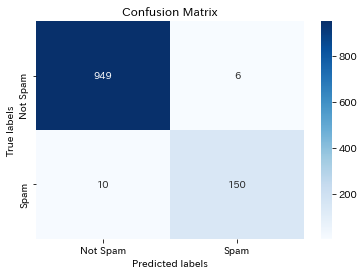

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()

#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);